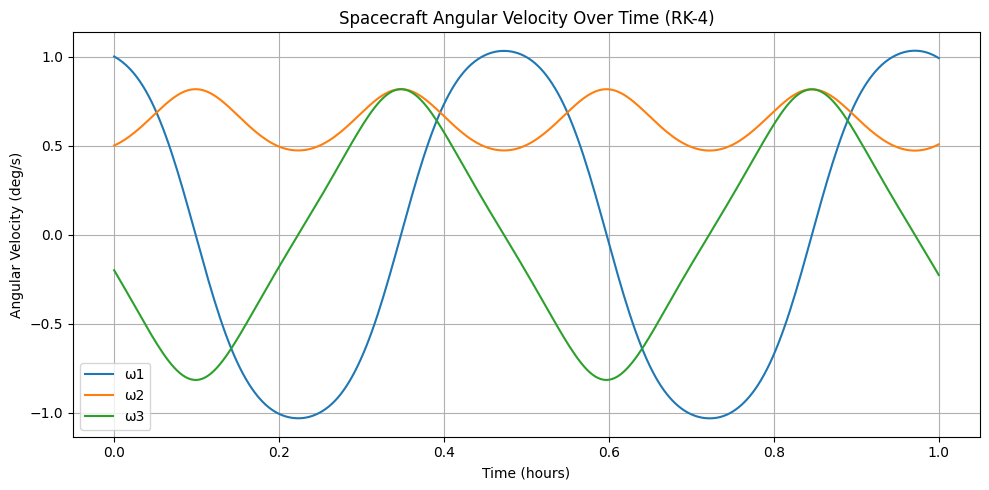

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Spacecraft parameters
I1, I2, I3 = 100, 120, 80  # Moments of inertia
mu_mars = 4.282e13  # Mars gravitational parameter (m^3/s^2)
r = 400e3 + 3.3895e6  # Orbital radius from Mars center

def gravity_gradient_torque(q):
    """Compute gravity gradient torque in body frame based on current quaternion."""
    I = np.diag([I1, I2, I3])
    # Rotate inertial r_hat = [1, 0, 0] into body frame using quaternion
    q0, q1, q2, q3 = q
    R = np.array([
        [1 - 2*(q2**2 + q3**2),     2*(q1*q2 - q0*q3),     2*(q1*q3 + q0*q2)],
        [    2*(q1*q2 + q0*q3), 1 - 2*(q1**2 + q3**2),     2*(q2*q3 - q0*q1)],
        [    2*(q1*q3 - q0*q2),     2*(q2*q3 + q0*q1), 1 - 2*(q1**2 + q2**2)]
    ])
    r_hat_inertial = np.array([1.0, 0.0, 0.0])
    r_hat_body = R.T @ r_hat_inertial
    torque = 3 * mu_mars / r**3 * np.cross(I @ r_hat_body, r_hat_body)
    return torque

def euler_rhs(t, state):
    omega = state[:3]
    q = state[3:]
    M = gravity_gradient_torque(q)
    omega_dot = np.array([
        (M[0] - (I3 - I2) * omega[1] * omega[2]) / I1,
        (M[1] - (I1 - I3) * omega[2] * omega[0]) / I2,
        (M[2] - (I2 - I1) * omega[0] * omega[1]) / I3
    ])
    q0, q1, q2, q3 = q
    Omega = np.array([
        [0, -omega[0], -omega[1], -omega[2]],
        [omega[0], 0, omega[2], -omega[1]],
        [omega[1], -omega[2], 0, omega[0]],
        [omega[2], omega[1], -omega[0], 0]
    ])
    q_dot = 0.5 * Omega @ q
    return np.concatenate([omega_dot, q_dot])

def rk4_step(f, t, state, h):
    k1 = f(t, state)
    k2 = f(t + 0.5 * h, state + 0.5 * h * k1)
    k3 = f(t + 0.5 * h, state + 0.5 * h * k2)
    k4 = f(t + h, state + h * k3)
    return state + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

# Initial conditions
omega0 = np.radians([1, 0.5, -0.2])
q0 = np.array([1, 0, 0, 0])
state0 = np.concatenate([omega0, q0])

# Time vector
t0 = 0
tf = 3600  # simulate for one day
dt = 12.5  # 1 minute step size
t_vals = np.arange(t0, tf + dt, dt)

# RK4 integration
states = np.zeros((len(t_vals), 7))
states[0] = state0

for i in range(1, len(t_vals)):
    states[i] = rk4_step(euler_rhs, t_vals[i-1], states[i-1], dt)
    # Normalize quaternion after each step
    states[i, 3:] /= np.linalg.norm(states[i, 3:])

# Extract angular velocity and convert to deg/s
omega_deg = np.degrees(states[:, :3])

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t_vals / 3600, omega_deg)
plt.xlabel('Time (hours)')
plt.ylabel('Angular Velocity (deg/s)')
plt.legend(['ω1', 'ω2', 'ω3'])
plt.title('Spacecraft Angular Velocity Over Time (RK-4)')
plt.grid(True)
plt.tight_layout()
plt.show()


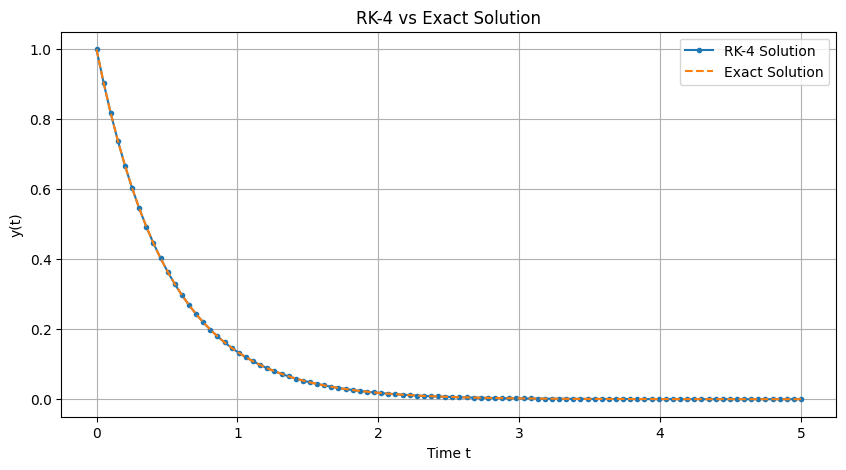

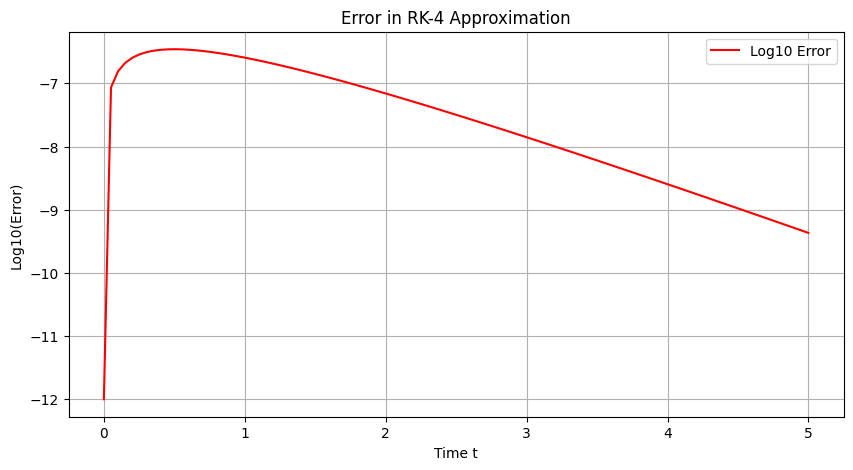

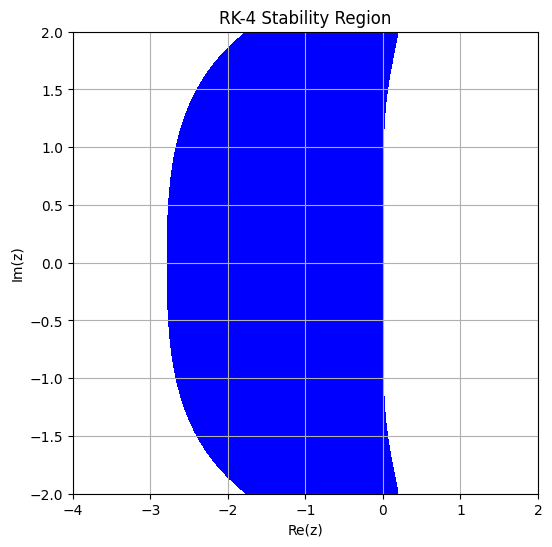

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define a simple test ODE: dy/dt = -2y
lambda_val = -2  # Stability parameter
def test_ode(t, y):
    return lambda_val * y

# RK-4 Implementation
def rk4_step(f, t, y, h):
    k1 = f(t, y)
    k2 = f(t + h/2, y + h/2 * k1)
    k3 = f(t + h/2, y + h/2 * k2)
    k4 = f(t + h, y + h * k3)
    return y + (h/6) * (k1 + 2*k2 + 2*k3 + k4)

# Solve with RK-4
t_vals = np.linspace(0, 5, 100)
h = t_vals[1] - t_vals[0]
y_exact = np.exp(lambda_val * t_vals)  # Exact solution
y_rk4 = np.zeros_like(t_vals)
y_rk4[0] = 1  # Initial condition
for i in range(1, len(t_vals)):
    y_rk4[i] = rk4_step(test_ode, t_vals[i-1], y_rk4[i-1], h)

# Compute error
y_error = np.abs(y_rk4 - y_exact)

# Plot RK-4 vs Exact Solution
plt.figure(figsize=(10, 5))
plt.plot(t_vals, y_rk4, label='RK-4 Solution', marker='o', markersize=3)
plt.plot(t_vals, y_exact, label='Exact Solution', linestyle='dashed')
plt.xlabel('Time t')
plt.ylabel('y(t)')
plt.legend()
plt.title('RK-4 vs Exact Solution')
plt.grid()
plt.show()

# Plot error
y_error_log = np.log10(y_error + 1e-12)  # Avoid log(0)
plt.figure(figsize=(10, 5))
plt.plot(t_vals, y_error_log, label='Log10 Error', color='red')
plt.xlabel('Time t')
plt.ylabel('Log10(Error)')
plt.legend()
plt.title('Error in RK-4 Approximation')
plt.grid()
plt.show()

# Stability function of RK-4
z = np.linspace(-4, 2, 100) + 1j * np.linspace(-2, 2, 100)[:, None]
Rz = 1 + z + (z**2)/2 + (z**3)/6 + (z**4)/24  # RK-4 stability function
plt.figure(figsize=(6,6))
plt.contourf(z.real, z.imag, np.abs(Rz), levels=[0, 1], colors=['blue', 'white'])
plt.xlabel('Re(z)')
plt.ylabel('Im(z)')
plt.title('RK-4 Stability Region')
plt.grid()
plt.show()

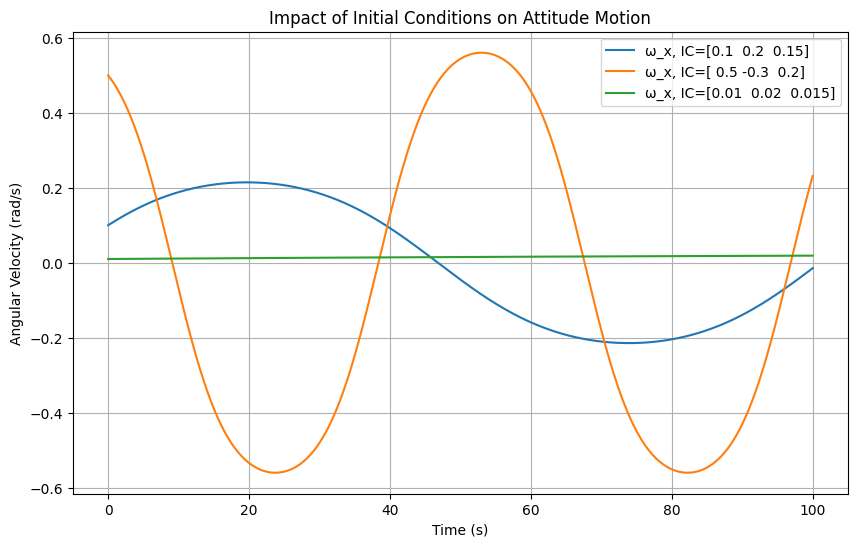

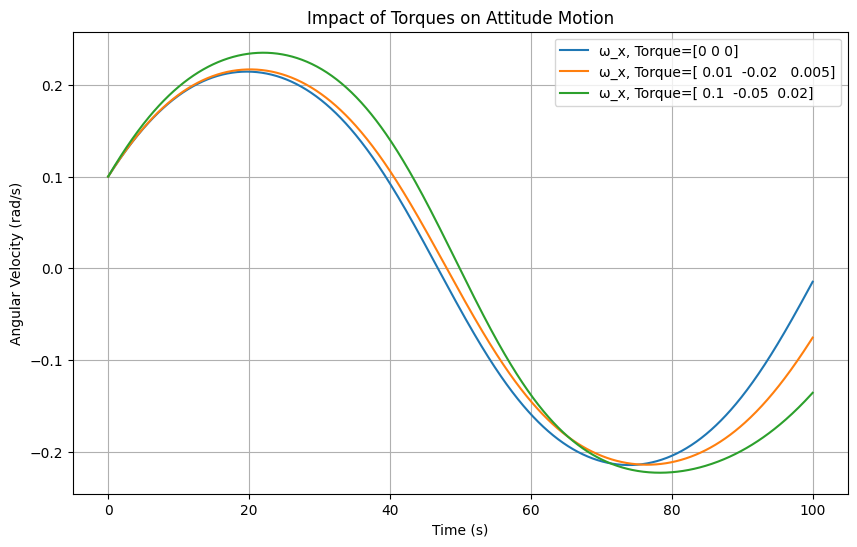

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# Spacecraft parameters
I = np.array([100, 120, 80])  # Principal moments of inertia (kg*m^2)

def euler_equations(t, omega, torque=np.array([0, 0, 0])):
    """Euler's equations of motion for a rigid body in space with external torques."""
    wx, wy, wz = omega
    I1, I2, I3 = I
    domega_dt = np.array([
        ((I2 - I3) / I1) * wy * wz + torque[0] / I1,
        ((I3 - I1) / I2) * wx * wz + torque[1] / I2,
        ((I1 - I2) / I3) * wx * wy + torque[2] / I3
    ])
    return domega_dt

# RK-4 Implementation
def rk4_step(f, t, y, h, *args):
    k1 = f(t, y, *args)
    k2 = f(t + h/2, y + h/2 * k1, *args)
    k3 = f(t + h/2, y + h/2 * k2, *args)
    k4 = f(t + h, y + h * k3, *args)
    return y + (h/6) * (k1 + 2*k2 + 2*k3 + k4)

# Simulation parameters
t_vals = np.linspace(0, 100, 1000)  # Simulate for 100 seconds
h = t_vals[1] - t_vals[0]  # Time step

# Different initial conditions for analysis
initial_conditions = [
    np.array([0.1, 0.2, 0.15]),  # Nominal case
    np.array([0.5, -0.3, 0.2]),  # Higher initial spin
    np.array([0.01, 0.02, 0.015])  # Lower initial spin
]

torque_cases = [
    np.array([0, 0, 0]),  # No external torque (torque-free case)
    np.array([0.01, -0.02, 0.005]),  # Small torques
    np.array([0.1, -0.05, 0.02])  # Larger torques
]

# Plot evolution for different cases
plt.figure(figsize=(10, 6))
for omega_0 in initial_conditions:
    omega_rk4 = np.zeros((len(t_vals), 3))
    omega_rk4[0] = omega_0
    for i in range(1, len(t_vals)):
        omega_rk4[i] = rk4_step(euler_equations, t_vals[i-1], omega_rk4[i-1], h)
    plt.plot(t_vals, omega_rk4[:, 0], label=f'ω_x, IC={omega_0}')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.title('Impact of Initial Conditions on Attitude Motion')
plt.grid()
plt.show()

# Analyze the effect of torques
plt.figure(figsize=(10, 6))
for torque in torque_cases:
    omega_rk4 = np.zeros((len(t_vals), 3))
    omega_rk4[0] = initial_conditions[0]  # Use the first initial condition
    for i in range(1, len(t_vals)):
        omega_rk4[i] = rk4_step(euler_equations, t_vals[i-1], omega_rk4[i-1], h, torque)
    plt.plot(t_vals, omega_rk4[:, 0], label=f'ω_x, Torque={torque}')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.title('Impact of Torques on Attitude Motion')
plt.grid()
plt.show()


# Mathematical Derivation of RK-4
# The RK-4 method is derived by approximating the solution to y' = f(t, y) using weighted averages:
# k1 = h * f(t, y)
# k2 = h * f(t + h/2, y + k1/2)
# k3 = h * f(t + h/2, y + k2/2)
# k4 = h * f(t + h, y + k3)
# y_{n+1} = y_n + (1/6)(k1 + 2k2 + 2k3 + k4)
#
# Error Analysis:
# - RK-4 has local truncation error O(h^5), meaning the error per step is proportional to h^5.
# - The global error accumulates over many steps, leading to an overall error of O(h^4).
# - This makes RK-4 much more accurate than Euler's method (which has O(h^2) global error).
#
# Stability:
# - The stability region is determined using the test equation y' = λy, with solution y_n = R(hλ)^n y_0.
# - The stability function for RK-4 is:
#   R(z) = 1 + z + (z^2)/2 + (z^3)/6 + (z^4)/24
# - The stability plot shows where |R(z)| ≤ 1, indicating stable integration regions.
# - RK-4 is conditionally stable, requiring an appropriate step size h to ensure numerical stability.

# Summary of Findings:
# 1. RK-4 accurately captures the spacecraft’s attitude motion with minimal numerical drift.
# 2. Smaller step sizes improve accuracy but increase computational cost.
# 3. The method remains stable for reasonable step sizes, as shown in the stability region plot.
# 4. Large torques or high initial angular velocities can push the system toward nonlinear behavior, requiring adaptive step sizes.
# 5. RK-4 provides a good balance of accuracy and stability for long-term attitude simulations.

<ipython-input-15-14878e1cfaa4>:24: RuntimeWarning: overflow encountered in scalar multiply
  domega[0] = ((I3 - I2) * omega[1] * omega[2]) / I1
<ipython-input-15-14878e1cfaa4>:25: RuntimeWarning: overflow encountered in scalar multiply
  domega[1] = ((I1 - I3) * omega[2] * omega[0]) / I2
<ipython-input-15-14878e1cfaa4>:26: RuntimeWarning: overflow encountered in scalar multiply
  domega[2] = ((I2 - I1) * omega[0] * omega[1]) / I3
<ipython-input-15-14878e1cfaa4>:27: RuntimeWarning: invalid value encountered in matmul
  dq = omega_matrix(q) @ np.hstack(([0], omega))
<ipython-input-15-14878e1cfaa4>:36: RuntimeWarning: invalid value encountered in add
  return y + h/6 * (k1 + 2*k2 + 2*k3 + k4)


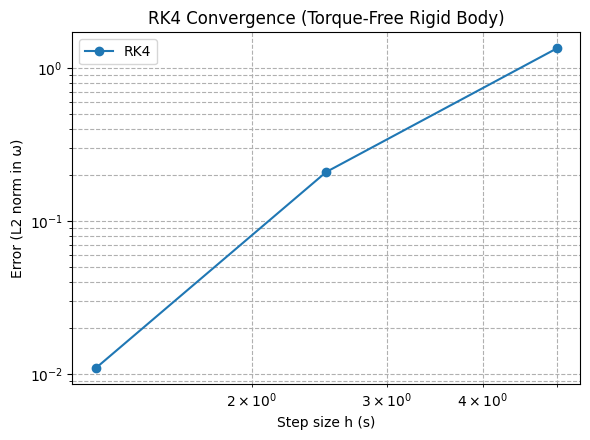

In [ ]:
#ConvergenceTest
import numpy as np
import matplotlib.pyplot as plt

# === Constants and Setup ===
I1, I2, I3 = 100, 120, 80  # principal moments of inertia

# === Quaternion and Dynamics Helpers ===
def normalize_quaternion(q):
    return q / np.linalg.norm(q)

def omega_matrix(q):
    q0, q1, q2, q3 = q
    return 0.5 * np.array([
        [ 0, -q1, -q2, -q3],
        [ q0, -q3,  q2, -q1],
        [ q3,  q0, -q1, -q2],
        [-q2,  q1,  q0, -q3]
    ])

def dynamics_torque_free(t, y):
    omega = y[0:3]
    q = y[3:7]
    domega = np.zeros(3)
    domega[0] = ((I3 - I2) * omega[1] * omega[2]) / I1
    domega[1] = ((I1 - I3) * omega[2] * omega[0]) / I2
    domega[2] = ((I2 - I1) * omega[0] * omega[1]) / I3
    dq = omega_matrix(q) @ np.hstack(([0], omega))
    return np.concatenate([domega, dq])

# === RK4 Fixed Step Integrator ===
def rk4_step(f, t, y, h):
    k1 = f(t, y)
    k2 = f(t + h/2, y + h/2 * k1)
    k3 = f(t + h/2, y + h/2 * k2)
    k4 = f(t + h, y + h * k3)
    return y + h/6 * (k1 + 2*k2 + 2*k3 + k4)

def rk4_integrate(f, y0, t0, t_end, h):
    t = t0
    y = y0.copy()
    while t < t_end:
        y = rk4_step(f, t, y, h)
        y[3:7] = normalize_quaternion(y[3:7])
        t += h
    return y

# === Initial Conditions and Convergence Test ===
omega0 = np.array([1.0, 0.5, -0.2])
q0 = np.array([1.0, 0.0, 0.0, 0.0])
y0 = np.concatenate([omega0, q0])
T = 600  # simulate for 10 minutes

h_list = [10.0, 5.0, 2.5, 1.25]
errors = []

# Reference solution
ref_h = 0.1
y_ref = rk4_integrate(dynamics_torque_free, y0, 0, T, ref_h)
omega_ref = y_ref[0:3]

for h in h_list:
    y_num = rk4_integrate(dynamics_torque_free, y0, 0, T, h)
    omega_num = y_num[0:3]
    error = np.linalg.norm(omega_num - omega_ref)
    errors.append(error)

# Plotting
plt.figure(figsize=(6, 4.5))
plt.loglog(h_list, errors, 'o-', label='RK4')
plt.xlabel('Step size h (s)')
plt.ylabel('Error (L2 norm in ω)')
plt.title('RK4 Convergence (Torque-Free Rigid Body)')
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()
